<a href="https://colab.research.google.com/github/llleyelll/food-classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Kaggle
fetch the dataset from kaggle.com to colab

In [3]:
! pip install -q kaggle

Setup kaggle.json in order to fetch the dataset

In [4]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-28 17:13:57           3822  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2222  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            478  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1410  
mathurinache/twitter-edge-nodes           

Fetch the dataset from kaggle

In [5]:
! kaggle datasets download -d trolukovich/food11-image-dataset
! mkdir train
! unzip food11-image-dataset.zip -d food_data

Streaming output truncated to the last 5000 lines.
  inflating: food_data/training/Soup/223.jpg  
  inflating: food_data/training/Soup/224.jpg  
  inflating: food_data/training/Soup/225.jpg  
  inflating: food_data/training/Soup/226.jpg  
  inflating: food_data/training/Soup/227.jpg  
  inflating: food_data/training/Soup/228.jpg  
  inflating: food_data/training/Soup/229.jpg  
  inflating: food_data/training/Soup/23.jpg  
  inflating: food_data/training/Soup/230.jpg  
  inflating: food_data/training/Soup/231.jpg  
  inflating: food_data/training/Soup/232.jpg  
  inflating: food_data/training/Soup/233.jpg  
  inflating: food_data/training/Soup/234.jpg  
  inflating: food_data/training/Soup/235.jpg  
  inflating: food_data/training/Soup/236.jpg  
  inflating: food_data/training/Soup/237.jpg  
  inflating: food_data/training/Soup/238.jpg  
  inflating: food_data/training/Soup/239.jpg  
  inflating: food_data/training/Soup/24.jpg  
  inflating: food_data/training/Soup/240.jpg  
  inflating

In [39]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import PIL
from IPython.display import Image
import numpy as np
from random import sample
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
keras = tf.keras
layers = keras.layers

In [7]:
PATH = './food_data'

data_dir = pathlib.Path(PATH)
train_dir = pathlib.Path(PATH + '/training')
val_dir = pathlib.Path(PATH + '/validation')

list_ds = tf.data.Dataset.list_files(str(data_dir/'training/*/*.jpg'))

NUM_CLASSES = len(list(list_ds))
print(NUM_CLASSES)

BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=10

9866


## Data Preprocessing

Training and Validation Sets

In [8]:
# training dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# validation dataset
validation_ds = keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.


Get class names


In [9]:
CLASS_NAMES = train_ds.class_names
print(f'Number of categories: {len(CLASS_NAMES)}')
print(CLASS_NAMES)

counts = {}
for c in CLASS_NAMES:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

Number of categories: 11
['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Total number of images in dataset: 9866


Example of dataset

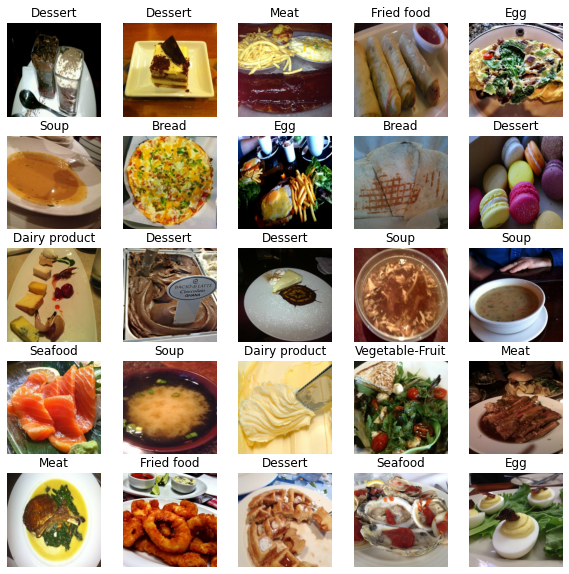

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

## Dataset distribution

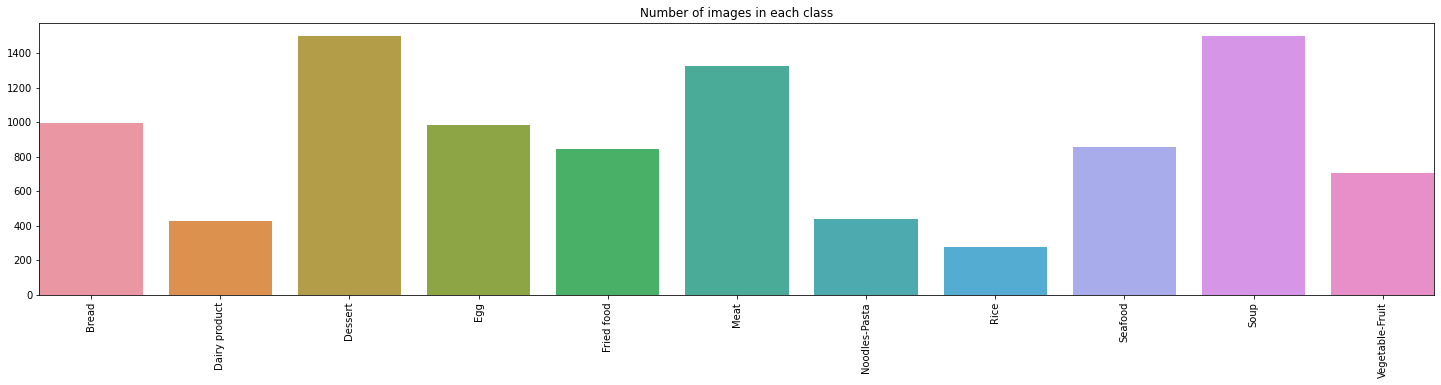

In [38]:
fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

## Image Augmentation

In [10]:
experimental = keras.layers.experimental

img_augmentation = keras.Sequential(
    [
        experimental.preprocessing.RandomRotation(factor=0.2),
        experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        experimental.preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

Augmentation Result

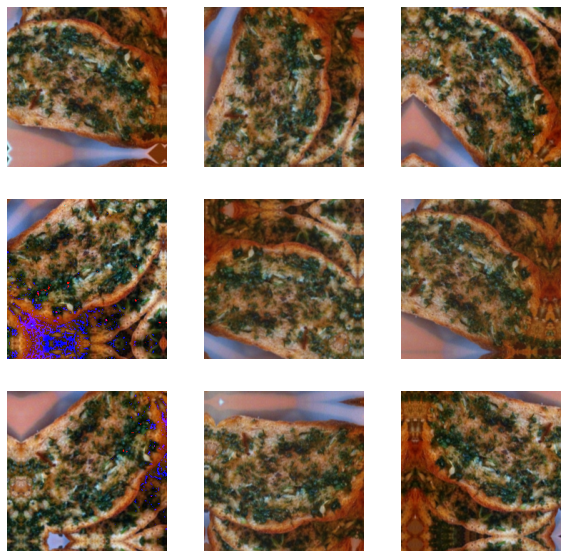

In [11]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

## Build Model

In [45]:
img_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

inputs = layers.Input(shape=img_shape)
augmented = img_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=augmented, weights="imagenet")
base_model.trainable = False
base_model.summary()

model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.BatchNormalization())

# model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           img_augmentation[8][0]           
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 224, 224, 3)  7           rescaling_6[0][0]                
_____________________________________________________________________________________

In [46]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
78/78 [==============================] - 65s 742ms/step - loss: 2.4434 - accuracy: 0.5803 - val_loss: 0.8103 - val_accuracy: 0.7598
Epoch 2/10
78/78 [==============================] - 59s 724ms/step - loss: 0.7067 - accuracy: 0.7674 - val_loss: 0.5722 - val_accuracy: 0.8268
Epoch 3/10
78/78 [==============================] - 59s 721ms/step - loss: 0.5225 - accuracy: 0.8312 - val_loss: 0.4797 - val_accuracy: 0.8472
Epoch 4/10
78/78 [==============================] - 59s 722ms/step - loss: 0.5245 - accuracy: 0.8225 - val_loss: 0.4287 - val_accuracy: 0.8580
Epoch 5/10
78/78 [==============================] - 59s 723ms/step - loss: 0.4210 - accuracy: 0.8578 - val_loss: 0.4256 - val_accuracy: 0.8580
Epoch 6/10
78/78 [==============================] - 58s 718ms/step - loss: 0.3889 - accuracy: 0.8696 - val_loss: 0.4128 - val_accuracy: 0.8638
Epoch 7/10
78/78 [==============================] - 59s 722ms/step - loss: 0.3728 - accuracy: 0.8704 - val_loss: 0.4631 - val_accuracy: 0.8569

## Evaluating Performance of Model

In [48]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

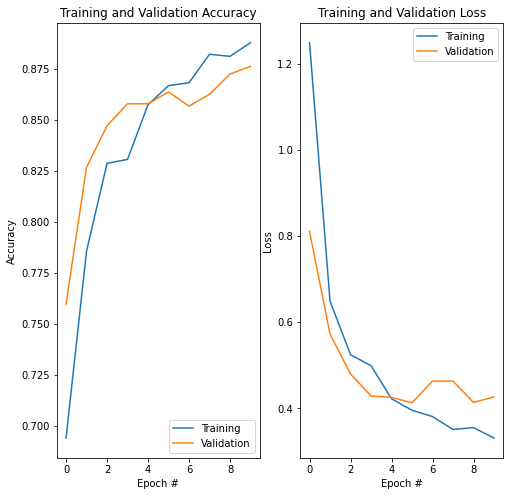

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training')
plt.plot(epochs_range, val_accuracy, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.show()

In [50]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    validation_ds, 
    batch_size=BATCH_SIZE
)

print('Accuracy Test : {}'.format(evaluate[1]))

27/27 [==============================] - 16s 493ms/step - loss: 0.4265 - accuracy: 0.8764
Accuracy Test : 0.8763848543167114


Save model

In [ ]:
model.save('trained.h5')

## Prediction

In [51]:
from keras.preprocessing import image

prediction = []
original = []
images = []
path_eval = PATH + '/evaluation'

for i in os.listdir(path_eval):
    for file_name in os.listdir(os.path.join(path_eval, i)):
      # open image from evaluation dir
      img = PIL.Image.open(os.path.join(path_eval, i, file_name))
      # resize image to 224 x 224
      img = img.resize((224,224))
      images.append(img)
      # convert image to numpy array format 
      img_np = image.img_to_array(img)
      img_np = np.expand_dims(img_np, axis=0)
      image_matrix = np.vstack([img_np])
      # making prediction of the model
      result = model.predict(image_matrix, batch_size=BATCH_SIZE)
      # get the index of the highest value in the prediction
      predict = np.argmax(result[0])
      original.append(i)
      prediction.append(CLASS_NAMES[predict])

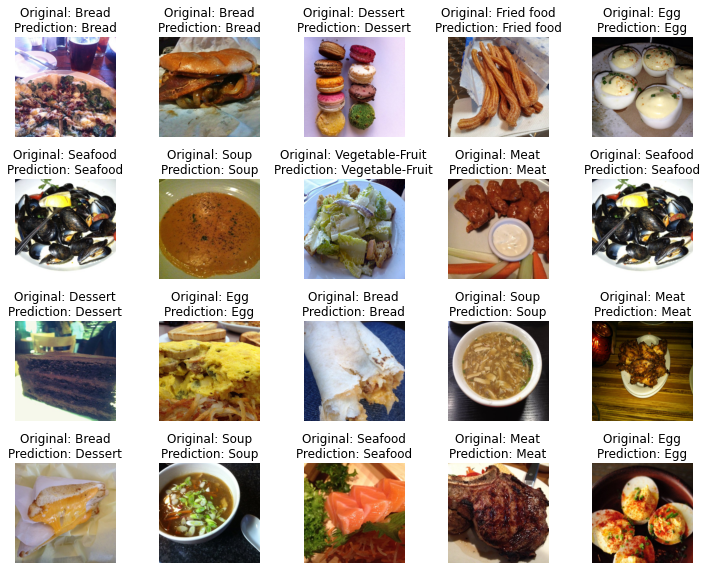

In [52]:
import random

# Visualizing the results
fig=plt.figure(figsize = (10,10))
for i in range(20):
    j = random.randint(0,len(images))
    fig.add_subplot(5, 5, i + 1)
    plt.title("Original: " + original[j] + "\nPrediction: " + prediction[j])
    plt.imshow(images[j])
    plt.axis("off")
fig.tight_layout()
plt.show()

## Classification Report

In [53]:
print(classification_report(np.asarray(prediction), np.asarray(original)))

                 precision    recall  f1-score   support

          Bread       0.82      0.89      0.85       338
  Dairy product       0.78      0.88      0.83       130
        Dessert       0.86      0.81      0.84       529
            Egg       0.89      0.83      0.86       358
     Fried food       0.86      0.88      0.87       281
           Meat       0.92      0.91      0.92       435
  Noodles-Pasta       0.98      0.97      0.97       149
           Rice       0.94      0.88      0.91       102
        Seafood       0.87      0.94      0.91       282
           Soup       0.97      0.95      0.96       510
Vegetable-Fruit       0.95      0.94      0.94       233

       accuracy                           0.89      3347
      macro avg       0.89      0.90      0.90      3347
   weighted avg       0.89      0.89      0.89      3347



## Confusion Matrix

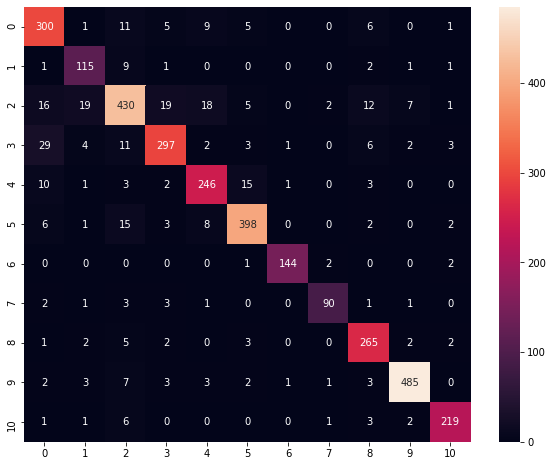

In [54]:
plt.figure(figsize = (10, 8))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm, 
    annot = True, 
    fmt = "d"
)
plt.show()